In [14]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

## Positional Encoding

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) # 초기화는 0으로
        position = torch.arange(0, max_len).unsqueeze(1).float()  # (max_len, 1), 각 위치별 포지션 만들기
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model/2, ), 논문에 나온 수식 그대로 적용

        pe[:, 0::2] = torch.sin(position * div_term)  # 짝수 index
        pe[:, 1::2] = torch.cos(position * div_term)  # 홀수 index

        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)  # (1, max_len, d_model)
        x = x + self.pe[:, :T, :]  # (1, max_len, d_model) + (1, T, d_model)
        return x  # (B, T, d_model)

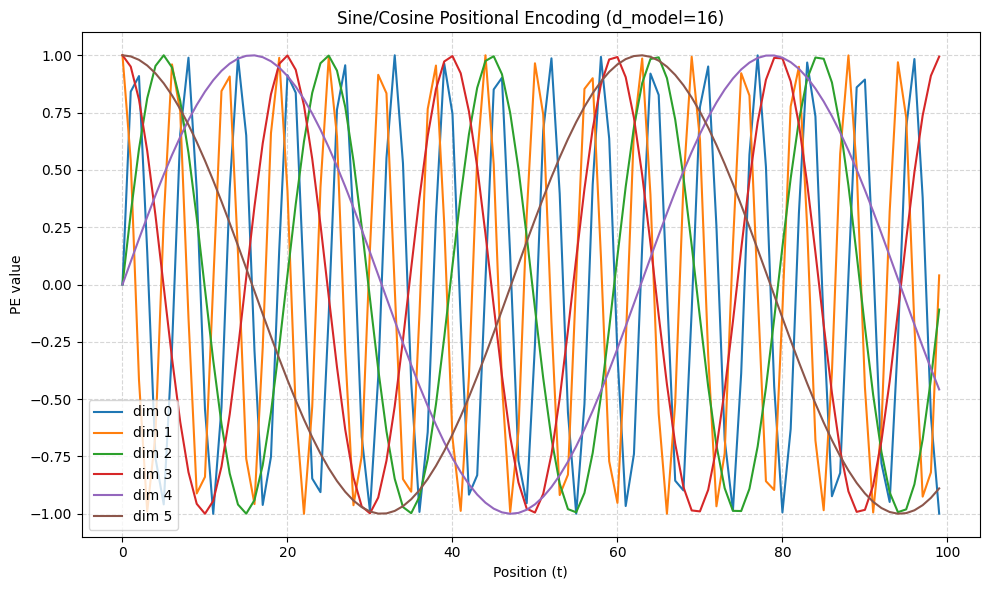

In [4]:
import matplotlib.pyplot as plt

def visualize_pe_curves(d_model=16, max_len=100):
    pe_module = PositionalEncoding(d_model=d_model, max_len=max_len)

    # (1, max_len, d_model)에서 batch=0만 사용
    pe = pe_module.pe[0, :max_len, :]  # (T, d_model)
    positions = torch.arange(0, max_len)

    # 보고 싶은 차원 인덱스들 (짝/홀 섞어서)
    dims_to_plot = [0, 1, 2, 3, 4, 5]

    plt.figure(figsize=(10, 6))
    for dim in dims_to_plot:
        plt.plot(positions, pe[:, dim].detach().cpu().numpy(), label=f"dim {dim}")

    plt.xlabel("Position (t)")
    plt.ylabel("PE value")
    plt.title(f"Sine/Cosine Positional Encoding (d_model={d_model})")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    visualize_pe_curves(d_model=16, max_len=100)

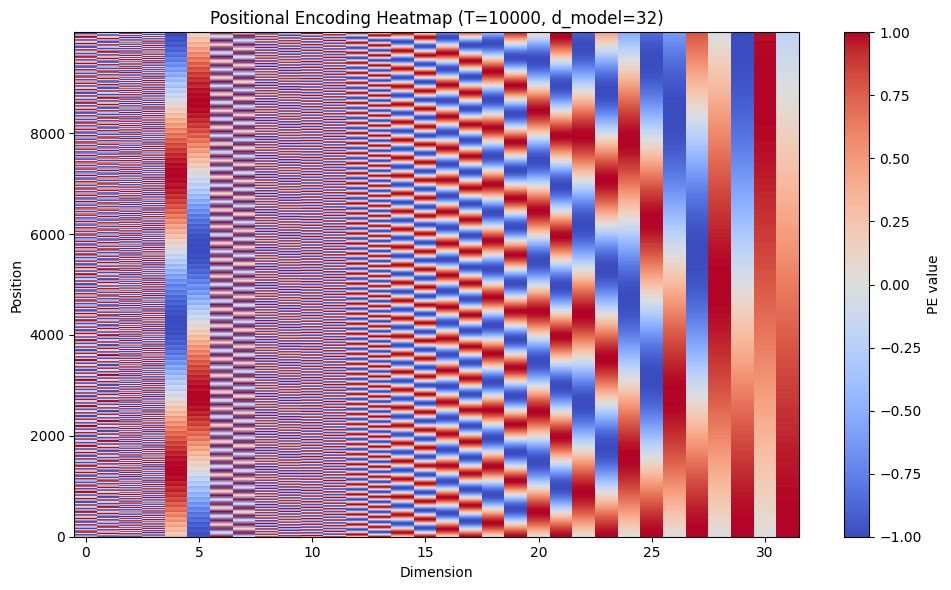

In [10]:
def visualize_pe_heatmap(d_model=32, max_len=100):
    pe_module = PositionalEncoding(d_model=d_model, max_len=max_len)
    pe = pe_module.pe[0, :max_len, :]  # (T, d_model)

    plt.figure(figsize=(10, 6))
    plt.imshow(
        pe.detach().cpu().numpy(),
        aspect="auto",
        origin="lower",
        cmap="coolwarm",
        interpolation="nearest",
    )
    plt.colorbar(label="PE value")
    plt.xlabel("Dimension")
    plt.ylabel("Position")
    plt.title(f"Positional Encoding Heatmap (T={max_len}, d_model={d_model})")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    visualize_pe_heatmap(d_model=32, max_len=10000)

## Multi-Head Attention

In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model should be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 각 head가 담당하는 차원 수

        # Q, K, V, 출력 투영을 위한 선형층
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)  # 여러 head 결과 concat하여 d_model 공간으로 돌리는 projection

        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        query: torch.Tensor,  # (B, T_q, d_model)
        key: torch.Tensor,    # (B, T_k, d_model)
        value: torch.Tensor,  # (B, T_k, d_model)
        mask: torch.Tensor | None = None,  # (B,1,T_q,T_k) or (1,1,T_q,T_k)
    ) -> torch.Tensor:

        B, T_q, _ = query.shape
        B, T_k, _ = key.shape

        # 1) Q, K, V 선형 변환
        Q = self.W_q(query)   # (B, T_q, d_model)
        K = self.W_k(key)     # (B, T_k, d_model)
        V = self.W_v(value)   # (B, T_k, d_model)

        # 2) head로 쪼개기: (B, T, d_model) → (B, num_heads, T, d_k)
        def split_heads(x, T):
            # x: (B, T, d_model)
            # view 후 transpose로 차원 재배치
            return x.view(B, T, self.num_heads, self.d_k).transpose(1, 2)
            # 결과: (B, num_heads, T, d_k)

        Q = split_heads(Q, T_q)  # (B, h, T_q, d_k)
        K = split_heads(K, T_k)  # (B, h, T_k, d_k)
        V = split_heads(V, T_k)  # (B, h, T_k, d_k)

        # 3) Scaled dot-product attention
        # scores: (B, h, T_q, T_k)
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)

        # 4) 마스크 적용 (padding / causal)
        if mask is not None:
            # mask: (B,1,T_q,T_k) 또는 (1,1,T_q,T_k), 값은 0 또는 -inf
            scores = scores + mask

        # 5) softmax → attention weight
        attn = scores.softmax(dim=-1)        # (B, h, T_q, T_k)
        attn = self.dropout(attn)

        # 6) 가중합: (B, h, T_q, T_k) @ (B, h, T_k, d_k) → (B, h, T_q, d_k)
        out = attn @ V

        # 7) head concat: (B, h, T_q, d_k) → (B, T_q, h*d_k = d_model)
        out = out.transpose(1, 2).contiguous().view(B, T_q, self.d_model)

        # 8) 최종 출력 선형층
        out = self.W_o(out)  # (B, T_q, d_model)
        return out


## Feed Forward Network

In [22]:
class PositionwiseFFN(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, d_model) → 각 토큰 위치마다 동일한 MLP 적용
        """
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


## Encoder Layer  (PE + MHA + Add&Norm + FFN + Add&Norm)

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, src_mask: torch.Tensor | None = None) -> torch.Tensor:
        """
        x: (B, T_src, d_model)
        src_mask: (B, 1, 1, T_src) or (1, 1, 1, T_src)
        """
        # --- 1) Self-Attention + Residual (pre-LN) ---
        x_norm = self.norm1(x)  # pre-LN
        attn_out = self.self_attn(x_norm, x_norm, x_norm, src_mask)
        x = x + self.dropout1(attn_out)

        # --- 2) FFN + Residual (pre-LN) ---
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout2(ffn_out)

        return x


## Decoder Layer (Masked-MHA + Cross-Attn + FFN)

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,           # (B, T_tgt, d_model)
        memory: torch.Tensor,      # (B, T_src, d_model) - encoder output
        tgt_mask: torch.Tensor | None = None,   # (B,1,T_tgt,T_tgt) causal+padding
        memory_mask: torch.Tensor | None = None # (B,1,T_tgt,T_src) padding
    ) -> torch.Tensor:

        # 1) Masked Self-Attention
        x_norm = self.norm1(x)
        self_attn_out = self.self_attn(x_norm, x_norm, x_norm, tgt_mask)
        x = x + self.dropout1(self_attn_out)

        # 2) Cross-Attention
        x_norm = self.norm2(x)
        cross_attn_out = self.cross_attn(
            query=x_norm,
            key=memory,
            value=memory,
            mask=memory_mask
        )
        x = x + self.dropout2(cross_attn_out)

        # 3) FFN
        x_norm = self.norm3(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout3(ffn_out)

        return x


## Transformer (Encoder + Decoder + Generator(`Linear -> vocab_logits`))

In [17]:
# Encoder / Decoder 스택

class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        num_layers: int,
        num_heads: int,
        d_ff: int,
        dropout: float = 0.1,
        max_len: int = 5000,
    ):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
        for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src_tokens: torch.Tensor, src_mask: Optional[torch.Tensor] = None):
        """
        src_tokens: (B, T_src)  - 토큰 인덱스
        src_mask: (B, 1, 1, T_src)
        """
        x = self.token_embed(src_tokens)          # (B, T_src, d_model)
        x = self.pos_encoding(x)                  # 위치 정보 추가
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, src_mask)                # (B, T_src, d_model)

        return x  # "memory"


class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        num_layers: int,
        num_heads: int,
        d_ff: int,
        dropout: float = 0.1,
        max_len: int = 5000,
    ):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
        for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        tgt_tokens: torch.Tensor,              # (B, T_tgt)
        memory: torch.Tensor,                  # (B, T_src, d_model)
        tgt_mask: Optional[torch.Tensor] = None,
        memory_mask: Optional[torch.Tensor] = None,
    ):
        x = self.token_embed(tgt_tokens)       # (B, T_tgt, d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, memory, tgt_mask, memory_mask)

        return x  # (B, T_tgt, d_model)


In [16]:
# Mask 유틸 (padding, causal-Mask)

def generate_padding_mask(seq: torch.Tensor, pad_idx: int) -> torch.Tensor:
    """
    seq: (B, T)
    return: mask (B, 1, 1, T) - attention score에 더할 값
      pad 위치: -inf, 나머지: 0
    """
    # True = pad 위치
    pad_mask = (seq == pad_idx).unsqueeze(1).unsqueeze(2)  # (B,1,1,T)
    mask = pad_mask.masked_fill(pad_mask, float("-inf"))
    return mask


def generate_subsequent_mask(T: int, device=None) -> torch.Tensor:
    """
    디코더용 causal mask (미래 토큰 가리기)
    return: (1, 1, T, T)
    """
    # 상삼각 (대각선 위) = 1 → 가려야할 위치
    mask = torch.triu(torch.ones(T, T), diagonal=1).bool()  # (T,T)
    mask = mask.unsqueeze(0).unsqueeze(0)                   # (1,1,T,T)
    mask = mask.masked_fill(mask, float("-inf"))
    if device is not None:
        mask = mask.to(device)
    return mask


In [27]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 512,
        num_layers: int = 6,
        num_heads: int = 8,
        d_ff: int = 2048,
        dropout: float = 0.1,
        pad_idx: int = 0,
        max_len: int = 5000,
    ):
        super().__init__()
        self.pad_idx = pad_idx

        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout,
            max_len=max_len,
        )
        self.decoder = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout,
            max_len=max_len,
        )

        # 디코더 출력 → vocab logits
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    # -------- encode / decode / forward 분리 --------
    def encode(self, src_tokens: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        src_tokens: (B, T_src)
        return: memory, src_mask
        """
        src_mask = generate_padding_mask(src_tokens, self.pad_idx)  # (B,1,1,T_src)
        memory = self.encoder(src_tokens, src_mask)                 # (B,T_src,d_model)
        return memory, src_mask

    def decode(
        self,
        tgt_tokens: torch.Tensor,         # (B, T_tgt)
        memory: torch.Tensor,             # (B, T_src, d_model)
        src_mask: torch.Tensor,           # (B,1,1,T_src)
    ) -> torch.Tensor:
        """
        디코더 hidden state (logits 전 단계)를 반환
        """
        B, T_tgt = tgt_tokens.shape
        device = tgt_tokens.device

        # 1) padding 마스크
        tgt_pad_mask = generate_padding_mask(tgt_tokens, self.pad_idx)  # (B,1,1,T_tgt)

        # 2) causal mask
        causal_mask = generate_subsequent_mask(T_tgt, device=device)    # (1,1,T_tgt,T_tgt)

        # 합치기: pad가 -inf, causal도 -inf → 둘 다 더하면 됨
        tgt_mask = tgt_pad_mask + causal_mask                           # (B,1,T_tgt,T_tgt)

        # cross-attn용 memory_mask: src padding만 가림
        memory_mask = src_mask.expand(B, -1, T_tgt, -1)  # (B,1,T_tgt,T_src)

        dec_output = self.decoder(
            tgt_tokens,
            memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
        )  # (B,T_tgt,d_model)

        return dec_output

    def forward(self, src_tokens: torch.Tensor, tgt_tokens: torch.Tensor) -> torch.Tensor:
        """
        학습 시:
          src_tokens: (B, T_src)
          tgt_tokens: (B, T_tgt)  → 보통 [BOS, ..., last-1] (입력용)
        출력:
          logits: (B, T_tgt, tgt_vocab_size)
        """
        memory, src_mask = self.encode(src_tokens)
        dec_output = self.decode(tgt_tokens, memory, src_mask)
        logits = self.generator(dec_output)
        return logits


## Model Test

In [31]:
for s_vocab, t_vocab in [(10,10), (100,100), (1000,1000)]:
    model = Transformer(s_vocab, t_vocab, d_model=64, num_layers=2, num_heads=4, d_ff=128)
    params = sum(p.numel() for p in model.parameters())
    print(f"src={s_vocab}, tgt={t_vocab} → Params: {params:,}")

src=10, tgt=10 → Params: 169,354
src=100, tgt=100 → Params: 186,724
src=1000, tgt=1000 → Params: 360,424


In [32]:
model = Transformer(
    src_vocab_size=100,
    tgt_vocab_size=120,
    d_model=64,
    num_layers=2,
    num_heads=4,
    d_ff=128
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}\n")

# (batch=2, seq_len_src=7, seq_len_tgt=5)
src_tokens = torch.tensor([
    [2, 5, 7, 9, 0, 0, 0],
    [3, 4, 8, 10, 11, 0, 0],
])

tgt_tokens = torch.tensor([
    [1, 20, 21, 0, 0],
    [1, 30, 31, 32, 0],
])


memory, src_mask = model.encode(src_tokens)
print(f"[Encoder output] memory.shape: {memory.shape}")
print(f"[Encoder mask] src_mask.shape: {src_mask.shape}\n")

dec_output = model.decode(tgt_tokens, memory, src_mask)
print(f"[Decoder output] shape: {dec_output.shape}\n")


logits = model(src_tokens, tgt_tokens)
print(f"[Final logits] shape: {logits.shape}")

# logits → 각 시퀀스 위치마다 vocab 분포
print(f"Example logits[0, 0, :5] = {logits[0,0,:5]}")

Total Parameters: 189,304

[Encoder output] memory.shape: torch.Size([2, 7, 64])
[Encoder mask] src_mask.shape: torch.Size([2, 1, 1, 7])

[Decoder output] shape: torch.Size([2, 5, 64])

[Final logits] shape: torch.Size([2, 5, 120])
Example logits[0, 0, :5] = tensor([-0.6777,  0.4446, -0.9252,  0.2318,  0.0469], grad_fn=<SliceBackward0>)
